In [1]:
# %% Cell 1: Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, levene
from pathlib import Path

sns.set(style="whitegrid")

In [2]:
# %% Cell 2: Interactive File Selection

def prompt_csv_paths():
    """
    Ask the user how many subgroup CSVs to load, then prompt for each path and a label.
    Returns a dict: {label: Path}
    """
    n = int(input("How many subgroup files (e.g. density, BI-RADS)? "))
    files = {}
    for i in range(1, n+1):
        label = input(f" Label for file #{i} (e.g. 'Density', 'BI-RADS'): ").strip()
        path = Path(input(f" Path to CSV for '{label}': ").strip())
        if not path.is_file():
            raise FileNotFoundError(f"Cannot find {path}")
        files[label] = path
    return files

subgroup_files = prompt_csv_paths()
print("\nLoaded subgroup files:")
for label,p in subgroup_files.items():
    print(f"  {label}: {p}")


# %% Cell 3: Loading Function

def load_subgroup_df(path: Path) -> pd.DataFrame:
    """
    Read a CSV with columns ['Dataset','Subgroup',metric1,...,metricK].
    Validates presence of 'Dataset' and 'Subgroup'.
    """
    df = pd.read_csv(path)
    if 'Dataset' not in df.columns or 'Subgroup' not in df.columns:
        raise ValueError(f"{path.name} must contain 'Dataset' and 'Subgroup' columns.")
    return df

How many subgroup files (e.g. density, BI-RADS)? 1
 Label for file #1 (e.g. 'Density', 'BI-RADS'): Density
 Path to CSV for 'Density': Consistency_density.csv

Loaded subgroup files:
  Density: Consistency_density.csv


In [3]:

# %% Cell 4: Compute Consistency Metrics (fixed MAD)

def compute_consistency(df: pd.DataFrame):
    """
    For each Dataset, compute across its Subgroups:
      - Variance, Range, CV, IQR, MAD for each metric
      - ANOVA p-value and Levene's p-value for each metric
    Returns a DataFrame indexed by Dataset with columns:
      [<metric>_var, <metric>_range, <metric>_cv,
       <metric>_iqr, <metric>_mad,
       <metric>_anova_p, <metric>_levene_p]
    """
    metrics = [c for c in df.columns if c not in ('Dataset','Subgroup')]
    records = []
    for ds, group in df.groupby('Dataset'):
        rec = {'Dataset': ds}
        data = group[metrics]

        # Basic stats
        var = data.var(ddof=0)
        rng = data.max() - data.min()
        cv  = data.std(ddof=0) / data.mean().replace(0, np.nan)
        iqr = data.quantile(0.75) - data.quantile(0.25)
        # Manual MAD: median(|x - median(x)|)
        mad = data.apply(lambda x: np.median(np.abs(x - np.median(x))))

        # ANOVA & Levene
        anova_p, levene_p = {}, {}
        for m in metrics:
            groups = [g[m].values for _,g in group.groupby('Subgroup')]
            if len(groups) >= 2:
                _, p_anova = f_oneway(*groups)
                _, p_lev   = levene(*groups)
            else:
                p_anova = np.nan
                p_lev   = np.nan
            anova_p[m]  = p_anova
            levene_p[m] = p_lev

        # Pack into record
        for m in metrics:
            rec[f"{m}_var"]     = var[m]
            rec[f"{m}_range"]   = rng[m]
            rec[f"{m}_cv"]      = cv[m]
            rec[f"{m}_iqr"]     = iqr[m]
            rec[f"{m}_mad"]     = mad[m]
            rec[f"{m}_anova_p"] = anova_p[m]
            rec[f"{m}_levene_p"]= levene_p[m]

        records.append(rec)

    return pd.DataFrame(records).set_index('Dataset')

In [4]:

# %% Cell 5: Visualization Utilities

def plot_metric_bars(df_metrics, group_label, stat_prefix):
    """
    Bar plot of a block of stats (e.g. var, range, cv) for each metric & dataset.
    stat_prefix: one of 'var','range','cv','iqr','mad'
    """
    cols = [c for c in df_metrics.columns if c.endswith(f"_{stat_prefix}")]
    df_plot = df_metrics[cols]
    df_plot.columns = [c.rsplit('_',1)[0] for c in cols]
    ax = df_plot.plot(kind='bar', figsize=(8,4))
    ax.set_title(f"{group_label}: {stat_prefix.upper()} Across Subgroups")
    ax.set_ylabel(stat_prefix.upper())
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05,1), title="Metric")
    plt.tight_layout()
    plt.show()

def plot_pvalue_heatmap(df_metrics, group_label, ptype):
    """
    Heatmap of ANOVA or Levene p-values.
    ptype: 'anova' or 'levene'
    """
    cols = [c for c in df_metrics.columns if c.endswith(f"_{ptype}_p")]
    df_plot = df_metrics[cols]
    df_plot.columns = [c.split('_')[0] for c in cols]
    plt.figure(figsize=(6,4))
    sns.heatmap(df_plot, annot=True, cmap='coolwarm_r', vmin=0, vmax=1)
    plt.title(f"{group_label}: {ptype.title()} p-values")
    plt.ylabel("Dataset")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()


def plot_box_and_violin(df, group_label):
    """
    For each metric, show side-by-side box & violin plots across subgroups faceted by Dataset.
    """
    metrics = [c for c in df.columns if c not in ('Dataset','Subgroup')]
    melted = df.melt(id_vars=['Dataset','Subgroup'], value_vars=metrics,
                     var_name='Metric', value_name='Value')
    for m in metrics:
        plt.figure(figsize=(6,3))
        sns.boxplot(x='Subgroup', y='Value', hue='Dataset', data=melted[melted.Metric==m])
        sns.violinplot(x='Subgroup', y='Value', hue='Dataset',
                       data=melted[melted.Metric==m],
                       split=True, inner="quart", alpha=0.3)
        plt.title(f"{group_label}: {m} by Subgroup")
        plt.legend(bbox_to_anchor=(1.05,1))
        plt.tight_layout()
        plt.show()


In [5]:
# %% Cell 7: Interactive Summary & Plots per Quality Metric

def interactive_consistency_review(metrics_df: pd.DataFrame, group_label: str):
    """
    1) Ask which quality metric(s) to tabulate (Correctness, Coverage, etc.)
    2) Show a small table for each chosen metric with its 7 stats:
       [Variance, Range, CV, IQR, MAD, ANOVA p, Levene p]
    3) Prompt for visualization choices (bar, heatmap, box/violin)
    4) Print a brief conclusion.
    """
    # 1) determine the list of quality metrics present
    stat_cols = [c for c in metrics_df.columns if '_' in c and not c.endswith('_p')]
    quality_metrics = sorted({col.rsplit('_',1)[0] for col in stat_cols})
    print(f"\nAvailable quality metrics: {', '.join(quality_metrics)}")
    sel = input("Enter metrics to show (comma-separated), or 'all': ").strip()
    if sel.lower()=='all':
        to_show = quality_metrics
    else:
        to_show = [s for s in [x.strip() for x in sel.split(',')] if s in quality_metrics]
    if not to_show:
        print("No valid metrics selected. Showing all.")
        to_show = quality_metrics

    # 2) display per-metric tables
    for m in to_show:
        cols = [
            f"{m}_var", f"{m}_range", f"{m}_cv",
            f"{m}_iqr", f"{m}_mad",
            f"{m}_anova_p", f"{m}_levene_p"
        ]
        subdf = metrics_df[cols].copy()
        subdf.columns = ['Variance','Range','CV','IQR','MAD','ANOVA p','Levene p']
        print(f"\n--- Summary for {m} ({group_label}) ---")
        display(subdf)

    # 3) ask for plots
    print("\nChoose visualizations (comma-separated):")
    print(" 1) Variance bar  2) Range heatmap  3) CV bar")
    print(" 4) IQR bar       5) MAD bar        6) ANOVA p-heatmap")
    print(" 7) Levene p-heatmap  8) Box+Violin")
    vis = [c.strip() for c in input("Enter choices e.g. 1,3,8: ").split(',')]

    for c in vis:
        if c=='1':
            plot_metric_bars(metrics_df, group_label, 'var')
        elif c=='2':
            plot_range_heatmap(metrics_df, group_label)
        elif c=='3':
            plot_metric_bars(metrics_df, group_label, 'cv')
        elif c=='4':
            plot_metric_bars(metrics_df, group_label, 'iqr')
        elif c=='5':
            plot_metric_bars(metrics_df, group_label, 'mad')
        elif c=='6':
            plot_pvalue_heatmap(metrics_df, group_label, 'anova')
        elif c=='7':
            plot_pvalue_heatmap(metrics_df, group_label, 'levene')
        elif c=='8':
            plot_box_and_violin(load_subgroup_df(subgroup_files[group_label]), group_label)
        else:
            print(f"Ignoring invalid choice: {c}")

    # 4) simple conclusion
    print(f"\n*** Conclusion for {group_label} subgroups ***")
    # rank by average variance
    var_cols = [col for col in metrics_df.columns if col.endswith('_var')]
    avg_vars = metrics_df[var_cols].mean(axis=1)
    best  = avg_vars.idxmin()
    worst = avg_vars.idxmax()
    print(f"- **{best}** has the lowest overall variance → most uniform across these subgroups.")
    print(f"- **{worst}** has the highest overall variance → least uniform.")



Available quality metrics: Constraint, Correctness, Coverage
Enter metrics to show (comma-separated), or 'all': all

--- Summary for Constraint (Density) ---


,Variance,Range,CV,IQR,MAD,ANOVA p,Levene p
Dataset,,,,,,,
HuggingFace,0.003150,0.15,0.075844,0.0750,0.045,NaN,NaN
MSYNTH,0.003125,0.15,0.077106,0.0750,0.050,NaN,NaN
Mammo-GAN,0.004119,0.15,0.087020,0.1125,0.055,NaN,NaN



--- Summary for Correctness (Density) ---


,Variance,Range,CV,IQR,MAD,ANOVA p,Levene p
Dataset,,,,,,,
HuggingFace,0.006019,0.21,0.135512,0.0825,0.045,NaN,NaN
MSYNTH,0.008750,0.25,0.170075,0.1000,0.050,NaN,NaN
Mammo-GAN,0.008925,0.25,0.167207,0.1300,0.075,NaN,NaN



--- Summary for Coverage (Density) ---


,Variance,Range,CV,IQR,MAD,ANOVA p,Levene p
Dataset,,,,,,,
HuggingFace,0.002419,0.12,0.066237,0.0825,0.045,NaN,NaN
MSYNTH,0.002450,0.13,0.068746,0.0700,0.040,NaN,NaN
Mammo-GAN,0.002600,0.12,0.067092,0.0900,0.050,NaN,NaN



Choose visualizations (comma-separated):
 1) Variance bar  2) Range heatmap  3) CV bar
 4) IQR bar       5) MAD bar        6) ANOVA p-heatmap
 7) Levene p-heatmap  8) Box+Violin
Enter choices e.g. 1,3,8: 5


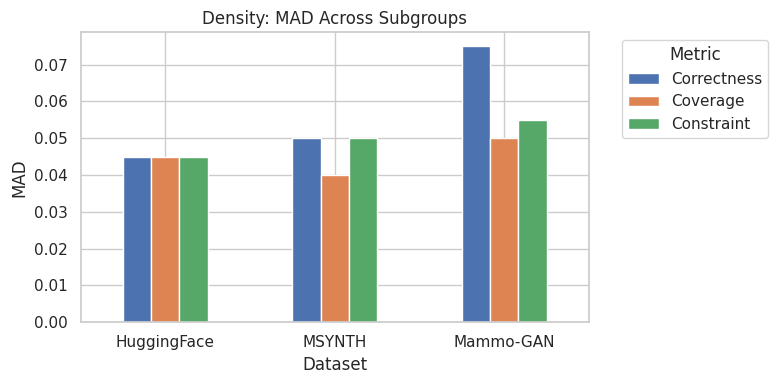


*** Conclusion for Density subgroups ***
- **HuggingFace** has the lowest overall variance → most uniform across these subgroups.
- **Mammo-GAN** has the highest overall variance → least uniform.


In [7]:

# === Run the interactive review for each subgroup file ===
for label, path in subgroup_files.items():
    # metrics_df was computed in Cell 6 for each label:
    df = load_subgroup_df(path)
    metrics_df = compute_consistency(df)
    interactive_consistency_review(metrics_df, label)
